In [363]:
import pandas as pd
import numpy as np
import re
from dotenv import load_dotenv
from openai import OpenAI

In [2]:
import os 

os.chdir('../')

In [364]:
load_dotenv()
client = OpenAI(api_key=os.getenv('API_KEY'))

In [ ]:
movies = pd.read_csv('data/new_movies.csv')
ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
tag_genome = pd.read_csv('data/ml-latest-small/tags.csv')
ratings_new = ratings[ratings['movieId'].isin(tag_genome.movieId.unique())]
movies_new = movies[movies['movieId'].isin(tag_genome.movieId.unique())]


movies = movies_new
ratings = ratings_new

In [200]:
movies = movies_new
ratings = ratings_new

### Plan <br>

1. setup item-item   DONE
2. setup randomized recommendations  DONE
3. setup chat-gpt user DONE
4. setup random-choice user  DONE  
5. tag-genome homogeneity
6. LLM Homogeniety DONE

In [359]:
movie_mapper = np.sort(np.array(movies.movieId.unique()))

def get_movie_hash(id):
    return np.where(movie_mapper == id)[0][0]

def get_movie_id(id):
    return movie_mapper[id]

def movie_names(movie_list):
    names = []
    for i in movie_list:
        names.append(movies[movies['movieId'] == i].title.values)
    return names

def movie_name_to_id(mov):
    return movies[movies['title'] == mov].movieId.values[0]

def extract_profile(text):
    pattern = r'<profile>(.*?)</profile>'
    match = re.search(pattern, text, re.DOTALL)
    return match.group(1).strip() if match else None

def extract_user_choice(text):
    chosen = re.search(r'<chosen>(.*?)<chosen/>', text)
    rating = re.search(r'<rating>(.*?)<rating/>', text)
    
    if chosen and rating:
        return chosen.group(1), float(rating.group(1))
    return None, None

def extract_score(text):
    match = re.search(r'<score>(.*?)<score/>', text)
    return float(match.group(1)) if match else None

In [202]:
from sklearn.neighbors import NearestNeighbors
import random

def collaborative_filtering(R, user_id, k=10):
    """
    Item-Item collaborative filtering implementation
    R: rating matrix (users x items)
    user_id: target user ID
    k: number of recommendations to return
    """
    # Transpose R to get item-item similarity matrix
    R_item = R.T  # Now each row represents an item's ratings across users
    
    # Get the items the user has rated
    user_ratings = R[user_id]
    rated_items = np.where(user_ratings != 0)[0]
    unrated_items = np.where(user_ratings == 0)[0]
    
    if len(rated_items) == 0:
        # If user hasn't rated anything, return random recommendations
        return random.sample(list(unrated_items), min(k, len(unrated_items)))
    
    # Initialize KNN for item similarity
    kNN = NearestNeighbors(n_neighbors=20, algorithm="brute", metric='cosine')
    kNN.fit(R_item)
    
    # Initialize predicted ratings
    predicted_ratings = np.zeros(R_item.shape[0])
    
    # For each unrated item
    for item in unrated_items:
        # Find k nearest items to current item
        distances, indices = kNN.kneighbors(R_item[item].reshape(1,-1), return_distance=True)
        neighbor_indices = indices[0]
        neighbor_distances = distances[0]
        
        # Convert distances to similarities
        similarities = 1 / (neighbor_distances + 1e-8)
        similarities = similarities / np.sum(similarities)
        
        # Get weighted sum of user's ratings for similar items
        weighted_sum = 0
        similarity_sum = 0
        
        for idx, neighbor_idx in enumerate(neighbor_indices):
            if neighbor_idx in rated_items:  # Only consider items the user has rated
                weighted_sum += similarities[idx] * user_ratings[neighbor_idx]
                similarity_sum += similarities[idx]
        
        # Calculate predicted rating
        if similarity_sum > 0:
            predicted_ratings[item] = weighted_sum / similarity_sum
    
    # Set predicted ratings to 0 for already rated items
    predicted_ratings[rated_items] = 0
    
    # Get top k recommendations
    recommendations = np.argsort(predicted_ratings)[::-1][:k]
    
    return list(recommendations)

In [203]:
def random_recommendations(k=10):
    ids = np.array(movies_new.movieId.unique())
    recommendations = np.random.choice(ids, size=k, replace=False)
    return recommendations

In [100]:
random_recommendations(10)

array([  2987,    534,   1266,   3967, 155288,   3385,    907,    371,
            7,    971], dtype=int64)

In [ ]:
class Environment:
    def __init__(self, ratings_df, movies_df):
        self.ratings = ratings_df.copy()  # Create a copy of the ratings DataFrame
        self.movies = movies_df.copy()
        
def create_R(agents, env):
    m = len(env.movies.movieId)
    R = []
    for agent in agents:
        mh = agent.movie_history
        mh_idx = list(map(get_movie_id, mh))
        user_ratings = env.ratings[(env.ratings['userId'] == agent.id) & 
                                 (env.ratings['movieId'].isin(mh_idx))]
        
        # Modified row creation with error handling
        row = []
        for i in range(m):
            if i in mh:
                # Get ratings for this movie
                movie_ratings = user_ratings[user_ratings['movieId'] == get_movie_id(i)].rating
                # Check if we have any ratings
                if len(movie_ratings) > 0:
                    row.append(float(movie_ratings.iloc[0]))
                else:
                    row.append(0)  # No rating found
            else:
                row.append(0)  # Movie not in history
                
        # Convert to numpy array for easier manipulation
        row_array = np.array(row)
        
        # Calculate mean of only non-zero elements
        non_zero_mask = row_array != 0
        if non_zero_mask.any():  # check if there are any non-zero elements
            mean = np.mean(row_array[non_zero_mask])
            # Subtract mean only from non-zero elements
            row_array[non_zero_mask] = row_array[non_zero_mask] - mean
        
        R.append(row_array.tolist())

    return np.array(R)

In [ ]:
class ReflexAgent:
    def __init__(self, id, env, k=10):
        self.id = id
        self.env = env  # Store reference to environment
        mh = list(self.env.ratings[self.env.ratings['userId'] == self.id]
                 .sort_values('timestamp').head(k).movieId)
        self.movie_history = list(map(get_movie_hash, mh))
    
    def get_recs(self, R):
        self.recs = collaborative_filtering(R, self.id)
        return self.recs
    
    def action(self):
        self.chosen = random.sample(self.recs, 1)[0]
        self.movie_history.append(self.chosen)

        # Create a new row as a DataFrame
        new_rating = pd.DataFrame({
            'userId': [self.id],
            'movieId': [get_movie_id(self.chosen)],
            'rating': [random.randint(0, 10)/2],
            'timestamp': [82983923]
        })
    
        # Update the ratings DataFrame in the environment
        self.env.ratings = pd.concat([self.env.ratings, new_rating], ignore_index=True)
        return self.chosen
    

In [352]:
class LLM_Agent:
    def __init__(self, id, env, k=10):
        self.id = id
        self.env = env  # Store reference to environment
        mh = list(self.env.ratings[self.env.ratings['userId'] == self.id]
                 .sort_values('timestamp').head(k).movieId)
        self.movie_history = list(map(get_movie_hash, mh))
        initial_ratings = list(self.env.ratings[self.env.ratings['userId'] == self.id]
                 .sort_values('timestamp').head(k).rating)
        self.profile = self.generate_profile(mh,initial_ratings)
    
    def get_recs(self, R, method = 'random'):

        if method == 'random':
            self.recs = random_recommendations(10)
    
        else:
            self.recs = collaborative_filtering(R, self.id)
        return self.recs
    
    def action(self):
        self.chosen, llm_rating = self.get_gpt_chosen(self.recs)
        self.chosen = movie_name_to_id(self.chosen)
        self.movie_history.append(get_movie_hash(self.chosen))

        # Create a new row as a DataFrame
        new_rating = pd.DataFrame({
            'userId': [self.id],
            'movieId': [self.chosen],
            'rating': [llm_rating],
            'timestamp': [82983923]
        })
    
        # Update the ratings DataFrame in the environment
        self.env.ratings = pd.concat([self.env.ratings, new_rating], ignore_index=True)
        return self.chosen
    

    def get_gpt_chosen(self,recommendations):
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f'''Based on the following user profile. Decide which movie the user will pick out of the recommendation list and what rating he is going to give it. You answer should be for the format:
<chosen>movie_name<chosen/> <rating>3<rating/>. MAKE SURE THE CHOSEN MOVIE HAS THE NAME IS WRITTEN THE SAME WAY AS THE MOVIES IN THE RECOMMENDATION LIST WITHOUT FAIL.


USER PROFILE:
{self.profile} 
RECOMMENDATIONS:
{movie_names(recommendations)}'''
                        }
                    ]
                }
            ],
            response_format={
                "type": "text"
            },
            temperature=1,
            max_tokens=1210,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )



        chosen, rating = extract_user_choice(response.choices[0].message.content)

        return chosen, rating
    

    def generate_profile(self,movie_list,initial_ratings):
        movie_list = movie_names(movie_list)
        rating_dict = {}
        for i in range(len(movie_list)):
            rating_dict[list(movie_list[i])[0]] = initial_ratings[i]
        
        ## llm request
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"Here is a dictionary which contains the movies a user has watched and the corresponding ratings given to them by the user. Your task is to create a user profile that describes what the user likes and dislikes and how he is likely to rate a movie. Observe the patterns in the ratings and the types of movies watched and think about what the user likes and dislikes and what movies he is likely to choose to watch. Enclose the user profile with <profile><profile/> tags. \n Watch History: \n {rating_dict}"
                        }
                    ]
                }
            ],
            response_format={
            "type": "text"
            },
            temperature=1,
            max_tokens=1210,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )


        ## save profile

        profile = extract_profile(response.choices[0].message.content)
        self.profile = profile
        return profile


In [206]:
# Create the environment
env = Environment(ratings, movies)

# Initialize agents with environment
users = np.array(pd.Series(ratings.userId.unique()).sample(n=10, random_state=42))
agents = [ReflexAgent(list(users).index(i), env) for i in users[:5]]

In [207]:
def simulation(timesteps,agents):
    # Run simulation
    recommendations = []
    chosen = []
    
    
    for t in range(timesteps):
        print(f"Creating R matrix for timestep {t}")
        R = create_R(agents, env)
        print(f"R matrix shape: {R.shape}")
        recs = []
        c = []
        for i, agent in enumerate(agents):
            #print(f"Processing agent {i} with {len(agent.movie_history)} movies in history")
            rec = agent.get_recs(R)
            recs.append(rec)
            c.append(agent.action())

        recommendations.append(recs)
        chosen.append(c)
        print(f"Completed timestep: {t}")
    return np.array(recommendations), np.array(chosen)

In [208]:
# Create Hooks at Recs and chosen objects 

recommendations, chosen  = simulation(10,agents)

Creating R matrix for timestep 0
R matrix shape: (5, 1572)
Completed timestep: 0
Creating R matrix for timestep 1
R matrix shape: (5, 1572)
Completed timestep: 1
Creating R matrix for timestep 2
R matrix shape: (5, 1572)
Completed timestep: 2
Creating R matrix for timestep 3
R matrix shape: (5, 1572)
Completed timestep: 3
Creating R matrix for timestep 4
R matrix shape: (5, 1572)
Completed timestep: 4
Creating R matrix for timestep 5
R matrix shape: (5, 1572)
Completed timestep: 5
Creating R matrix for timestep 6
R matrix shape: (5, 1572)
Completed timestep: 6
Creating R matrix for timestep 7
R matrix shape: (5, 1572)
Completed timestep: 7
Creating R matrix for timestep 8
R matrix shape: (5, 1572)
Completed timestep: 8
Creating R matrix for timestep 9
R matrix shape: (5, 1572)
Completed timestep: 9


In [209]:
recommendations.shape

(10, 5, 10)

#### Tag homogenity

In [257]:
from sklearn.preprocessing import LabelEncoder
def compute_homogeniety(recommendation):
    # Edge case: fewer than 2 movies
    if len(recommendation) < 2:
        return 0  # No meaningful distance to compute

    total_distance = 0
    num_pairs = 0


    # Pre-filter tag genome data for movies in the recommendation list
    filtered_tags = tag_genome[tag_genome['movieId'].isin(recommendation)].set_index('movieId')

    if len(filtered_tags) == 0:
        print(f"No tags")
        return 0
    
    

    le = LabelEncoder()
    filtered_tags.tag = le.fit_transform(filtered_tags.tag)

    
    # Compute pairwise distances for unique movie pairs
    for i, m1 in enumerate(recommendation):
        for m2 in recommendation[i + 1:]:  # Ensure unique pairs (m1 < m2)
            # Extract tag vectors for the two movies
            print(m1,m2)

            if m2 in filtered_tags.index and m1 in filtered_tags.index:
                vec1 = np.array(filtered_tags.loc[m1].tag)
                vec2 = np.array(filtered_tags.loc[m2].tag)
                

                if vec1.dtype == np.int32 and vec1.size == 1:
                    vec1 = vec1.reshape(1,)
                if vec2.dtype == np.int32 and vec2.size == 1:
                    vec2 = vec2.reshape(1,)
                max_len = max(vec1.size, vec2.size)
                vec1 = np.pad(vec1, (0, max_len - vec1.size))
                vec2 = np.pad(vec2, (0, max_len - vec2.size))

          
                
        
                # Compute Euclidean distance
                distance = np.linalg.norm(vec1 - vec2)

                # Update totals
                total_distance += distance
                num_pairs += 1

    # Return the inverse of average distance as the homogeneity
    return 1/(1+ (total_distance/num_pairs)) if num_pairs > 0 else -1

In [ ]:
scores = []
for i in range(len(recommendations)):
    for j in range(len(recommendations[0])):
        h = compute_homogeniety(recommendations[i][j])

        if isinstance(h, float):
            scores.append(h)
        else:
            scores.append(0.0)
            # print the pairs that don't return a float homogeneirty score
            print(h)

1333 1353
1333 9
1333 629
1333 1562
1333 432
1333 1105
1333 1226
1333 1295
1333 604
1353 9
1353 629
1353 1562
1353 432
1353 1105
1353 1226
1353 1295
1353 604
9 629
9 1562
9 432
9 1105
9 1226
9 1295
9 604
629 1562
629 432
629 1105
629 1226
629 1295
629 604
1562 432
1562 1105
1562 1226
1562 1295
1562 604
432 1105
432 1226
432 1295
432 604
1105 1226
1105 1295
1105 604
1226 1295
1226 604
1295 604
No tags
0
1571 515
1571 517
1571 518
1571 519
1571 520
1571 521
1571 522
1571 523
1571 524
515 517
515 518
515 519
515 520
515 521
515 522
515 523
515 524
517 518
517 519
517 520
517 521
517 522
517 523
517 524
518 519
518 520
518 521
518 522
518 523
518 524
519 520
519 521
519 522
519 523
519 524
520 521
520 522
520 523
520 524
521 522
521 523
521 524
522 523
522 524
523 524
760 912
760 487
760 9
760 644
760 1084
760 583
760 547
760 1473
760 1299
912 487
912 9
912 644
912 1084
912 583
912 547
912 1473
912 1299
487 9
487 644
487 1084
487 583
487 547
487 1473
487 1299
9 644
9 1084
9 583
9 547
9 147

In [260]:
scores

[0.5,
 0.0,
 0.20754134777713804,
 0.24705855250855374,
 0.20754134777713804,
 0.06927507268258347,
 0.4285714285714286,
 0.20754134777713804,
 0.20754134777713804,
 0.0,
 0.20754134777713804,
 0.14201509144592042,
 0.20754134777713804,
 0.0,
 0.0,
 0.20754134777713804,
 0.0,
 0.20754134777713804,
 0.3090169943749474,
 0.0,
 0.20754134777713804,
 0.0,
 0.0,
 0.2792865097050907,
 0.0,
 0.20754134777713804,
 0.0,
 0.0,
 0.2792865097050907,
 0.0,
 0.20754134777713804,
 0.0,
 0.0,
 0.2792865097050907,
 0.0,
 0.20754134777713804,
 0.0,
 0.0,
 0.2792865097050907,
 0.4142135623730951,
 0.3090169943749474,
 0.0,
 0.0,
 0.28989794855663564,
 0.0,
 0.20754134777713804,
 0.0,
 0.09427270035947487,
 0.10181395064886128,
 0.4142135623730951]

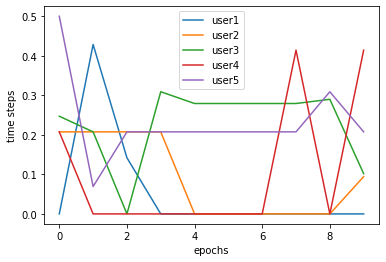

In [265]:
import  matplotlib.pyplot as plt

plt.plot([i for i in range(10)],[scores[i] for i in range(1,50,5)],label='user1')
plt.plot([i for i in range(10)],[scores[i] for i in range(2,50,5)],label='user2')
plt.plot([i for i in range(10)],[scores[i] for i in range(3,50,5)],label='user3')
plt.plot([i for i in range(10)],[scores[i] for i in range(4,50,5)],label='user4')
plt.plot([i for i in range(10)],[scores[i] for i in range(0,50,5)],label='user5')
plt.xlabel('epochs')
plt.ylabel('time steps')
plt.legend()


In [215]:
recommendations[0][0][1]

1353

In [262]:
tag_genome[tag_genome['movieId'] == 1333]

,userId,movieId,tag,timestamp
1411,474,1333,birds,1137202841


##### New Dataset manipulation (Not important can ignore)

In [90]:
len(tag_genome.movieId.unique())

1572

In [91]:
len(movies.movieId.unique())

9742

In [92]:
len(ratings.movieId.unique())

9724

In [93]:
len(ratings)

100836

In [96]:
ratings_new = ratings[ratings['movieId'].isin(tag_genome.movieId.unique())]
movies_new = movies[movies['movieId'].isin(tag_genome.movieId.unique())]

In [95]:
len(ratings_new)

48287

#### LLM Homogeneity

In [ ]:
def LLM_homogeneity(recommendations):
  movie_list = movie_names(recommendations)
  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"I want you to give me a homogeneity score between 0 and 10. The homogeneity score is how similar are the movies in a given list. The dimensions of similarity can range from genres to plotlines to whatever. MAKE SURE TO ENCLOSE YOUR FINAL SCORE WITH <score><score/> TAGS. Here is the list of movies:\n{movie_list}"
          }
        ]
      }
    ],
    response_format={
      "type": "text"
    },
    temperature=0,
    max_tokens=2048,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )

  score = extract_score(response.choices[0].message.content)
  return score/10

0.2


#### LLM Agents

In [353]:
llm_agents = [LLM_Agent(list(users).index(i), env,k=30) for i in users[:5]]

In [354]:
recommendations, chosen  = simulation(10,llm_agents)

Creating R matrix for timestep 0
R matrix shape: (5, 1572)
Completed timestep: 0
Creating R matrix for timestep 1
R matrix shape: (5, 1572)
Completed timestep: 1
Creating R matrix for timestep 2
R matrix shape: (5, 1572)
Completed timestep: 2
Creating R matrix for timestep 3
R matrix shape: (5, 1572)
Completed timestep: 3
Creating R matrix for timestep 4
R matrix shape: (5, 1572)
Completed timestep: 4
Creating R matrix for timestep 5
R matrix shape: (5, 1572)
Completed timestep: 5
Creating R matrix for timestep 6
R matrix shape: (5, 1572)
Completed timestep: 6
Creating R matrix for timestep 7
R matrix shape: (5, 1572)
Completed timestep: 7
Creating R matrix for timestep 8
R matrix shape: (5, 1572)
Completed timestep: 8
Creating R matrix for timestep 9
R matrix shape: (5, 1572)
Completed timestep: 9


In [347]:
llm_agents[4].chosen

'The Haunting (1963)'

In [351]:
movies[movies['movieId']== 2550]

,movieId,title,genres,actors,director
1922,2550,"Haunting, The (1963)",Horror|Thriller,[122],19


In [349]:
llm_agents[4].recs

array([ 4495, 89745,  2550,   616,  6188,  1125,  6963,  1625,  6297,
        7025], dtype=int64)

In [350]:
movie_names([ 4495, 89745,  2550,   616,  6188,  1125,  6963,  1625,  6297,
        7025])

[array(['Crossing Delancey (1988)'], dtype=object),
 array(['Avengers, The (2012)'], dtype=object),
 array(['Haunting, The (1963)'], dtype=object),
 array(['Aristocats, The (1970)'], dtype=object),
 array(['Old School (2003)'], dtype=object),
 array(['Return of the Pink Panther, The (1975)'], dtype=object),
 array(["Devil's Playground (2002)"], dtype=object),
 array(['Game, The (1997)'], dtype=object),
 array(['Holes (2003)'], dtype=object),
 array(['Midnight Clear, A (1992)'], dtype=object)]

In [357]:
recommendations.T

array([[[  1281,   5502,   1797,   6668,   6773,   1902,    371,   2302,
           6753,   4312],
        [  4312, 122912,   1136,    970,   2863,   7023,   1283,  41997,
           3310,   4980],
        [  2987,   1081,  64034,   1995,  33162,   5601,   1961,     38,
             11,   7834],
        [  2693,  40583,   6101,   7832,   2600,  81562,  96861, 118696,
           2059,    836],
        [  2797,  58295,   1230,   1580,   3897,     17,   1262,    903,
           3160,   4973]],

       [[  5451,   2396, 176371,    929,    515,   2202,   1996,   4263,
           2390,   2664],
        [  7444,   2642,   4558, 106782,    926,   3421, 180031,   1254,
           3087,   7440],
        [  7981,   3176,   5304,   6170,    858,   3115,   2471,   4823,
           3877,    412],
        [  2579,   3556,   4359,  95067,    900,   1285,   1125,   3536,
            736, 116797],
        [  2420,    349,   1207,   1975,   1260,   6984,    540,   2006,
           1084,   3556]],

      

In [358]:
movie_names( [  3087,  74791,     14,    474,   6181,   4184,    908,   2329,
           6744,   8879])

[array(['Scrooged (1988)'], dtype=object),
 array(['Town Called Panic, A (Panique au village) (2009)'], dtype=object),
 array(['Nixon (1995)'], dtype=object),
 array(['In the Line of Fire (1993)'], dtype=object),
 array(['Red Badge of Courage, The (1951)'], dtype=object),
 array(["Bishop's Wife, The (1947)"], dtype=object),
 array(['North by Northwest (1959)'], dtype=object),
 array(['American History X (1998)'], dtype=object),
 array(['Once Bitten (1985)'], dtype=object),
 array(['Murder on the Orient Express (1974)'], dtype=object)]